# 1. Import Necessary Libraries

In [61]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torchinfo 
import copy
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict ,List

# 2.Device Augnostic Code

In [2]:
device="cuda" if torch.cuda.is_available() else"cpu"
device

'cuda'

# 3.Data Augmentation 

In [3]:
from torchvision import transforms

imgSize = 224

# Training transformer
trainTransformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),

    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),

    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [4]:

#Prepare Dataset
train_data=torchvision.datasets.ImageFolder(root="Vegetable_Images/train",
                                            transform=trainTransformer)

val_data=torchvision.datasets.ImageFolder(root="Vegetable_Images/validation",
                                            transform=trainTransformer)

In [9]:
# Prepare Data Loader
Batch_Size=32

train_Dataloader=torch.utils.data.DataLoader(train_data,
                                            batch_size=Batch_Size,
                                            shuffle=True)

val_DataLoader=torch.utils.data.DataLoader(val_data,
                                            batch_size=Batch_Size,
                                            shuffle=True)


In [11]:
classes=train_data.classes
classes,len(classes)

(['Bean',
  'Bitter_Gourd',
  'Bottle_Gourd',
  'Brinjal',
  'Broccoli',
  'Cabbage',
  'Capsicum',
  'Carrot',
  'Cauliflower',
  'Cucumber',
  'Papaya',
  'Potato',
  'Pumpkin',
  'Radish',
  'Tomato'],
 15)

# 4. Model Selection

In [12]:
def create_model(num_classes,seed:int=42):
  
  # 1, 2, 3 Create Resnet50 pretrained weights, transforms and model
  weights=torchvision.models.ResNet50_Weights.DEFAULT.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.resnet50(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False


  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.fc = nn.Linear(model.fc.in_features, out_features=num_classes)

  return model

In [13]:
model=create_model(len(classes))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:

# Print ResNet50 model summary (uncomment for full output)
torchinfo.summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 15]              --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

# 5 Train and Test Loop

In [22]:
# Early stopping
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

In [20]:
criterions= torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
lr_scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

d:\Machine_Learning\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [23]:
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
scaler = GradScaler()


best_model=copy.deepcopy(model.state_dict())
best_acc=0.0

epochs=15

trainLosses = []
trainAcc=[]
valLosses = []
valAccs = []

for epoch in range(epochs):

  model.train()
  print(f'Epoch {epoch+1}/{epochs}')

  train_loss=0.0
  train_acc=0.0

  for (X, y) in tqdm(train_Dataloader,desc="Testing"):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    with autocast():

    # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = criterions(y_pred, y)

    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    scaler.scale(loss).backward()
    # 5. Optimizer step
    scaler.step(optimizer)

    scaler.update()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(train_Dataloader)
  train_acc = train_acc / len(train_Dataloader)
  trainLosses.append(train_loss)
  trainAcc.append(train_acc)

  val_loss, val_acc = 0, 0
  model.eval()

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for  (X, y) in tqdm(val_DataLoader,desc="Validation"):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = criterions(test_pred_logits, y)
        val_loss += loss.item()

        # Calculate and accumulate accuracy
        val_pred_labels = test_pred_logits.argmax(dim=1)
        val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(val_DataLoader)
    val_acc = val_acc / len(val_DataLoader)
      

  print(f'Training Loss : {train_loss:.2f} | Train Accuracy : {train_acc * 100:.2f}%')
  print(f'Validation Loss : {val_loss:.2f} | Validation Accuracy : {val_acc * 100:.2f}%')
  valLosses.append(val_loss)
  valAccs.append(val_acc)

  #Best acc model is saved
  if val_acc > best_acc:
     best_acc=val_acc
     best_model = copy.deepcopy(model.state_dict())

  # Early stopping
  if val_loss < bestLoss - minDelta:
      bestLoss = val_loss
      currentPatience = 0
  else:
      currentPatience += 1
      print(f"Current Patience {currentPatience}\n")  
      if currentPatience >= patience:
          print('Early stopping triggered.')
          break

  

  lr_scheduler.step(val_loss)


d:\Machine_Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/15


Validation: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Training Loss : 0.91 | Train Accuracy : 95.06%
Validation Loss : 0.66 | Validation Accuracy : 99.42%
Epoch 2/15


Validation: 100%|██████████| 94/94 [00:23<00:00,  4.07it/s]


Training Loss : 0.66 | Train Accuracy : 99.40%
Validation Loss : 0.64 | Validation Accuracy : 99.80%
Epoch 3/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.11it/s]


Training Loss : 0.64 | Train Accuracy : 99.71%
Validation Loss : 0.62 | Validation Accuracy : 99.80%
Epoch 4/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.09it/s]


Training Loss : 0.63 | Train Accuracy : 99.76%
Validation Loss : 0.62 | Validation Accuracy : 99.80%
Current Patience 1

Epoch 5/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.10it/s]


Training Loss : 0.62 | Train Accuracy : 99.82%
Validation Loss : 0.61 | Validation Accuracy : 99.97%
Current Patience 2

Epoch 6/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.24it/s]


Training Loss : 0.62 | Train Accuracy : 99.84%
Validation Loss : 0.61 | Validation Accuracy : 99.90%
Current Patience 3

Epoch 7/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.27it/s]


Training Loss : 0.62 | Train Accuracy : 99.91%
Validation Loss : 0.61 | Validation Accuracy : 99.93%
Current Patience 4

Epoch 8/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.25it/s]


Training Loss : 0.62 | Train Accuracy : 99.92%
Validation Loss : 0.61 | Validation Accuracy : 99.90%
Epoch 9/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.25it/s]


Training Loss : 0.61 | Train Accuracy : 99.93%
Validation Loss : 0.61 | Validation Accuracy : 99.93%
Current Patience 1

Epoch 10/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.24it/s]


Training Loss : 0.61 | Train Accuracy : 99.96%
Validation Loss : 0.61 | Validation Accuracy : 99.93%
Current Patience 2

Epoch 11/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.18it/s]


Training Loss : 0.61 | Train Accuracy : 99.93%
Validation Loss : 0.60 | Validation Accuracy : 99.97%
Current Patience 3

Epoch 12/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.20it/s]


Training Loss : 0.61 | Train Accuracy : 99.95%
Validation Loss : 0.60 | Validation Accuracy : 99.97%
Current Patience 4

Epoch 13/15


Validation: 100%|██████████| 94/94 [00:22<00:00,  4.15it/s]

Training Loss : 0.61 | Train Accuracy : 99.97%
Validation Loss : 0.60 | Validation Accuracy : 100.00%
Current Patience 5

Early stopping triggered.


# 6. Vizualizing Data

In [88]:
# Prepare dataset for unseen data
test_data=torchvision.datasets.ImageFolder(root="Vegetable_Images/test",
                                             transform=valTransformer)
# Prepare DataLoader 
test_DataLoader=DataLoader(test_data,
                           batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


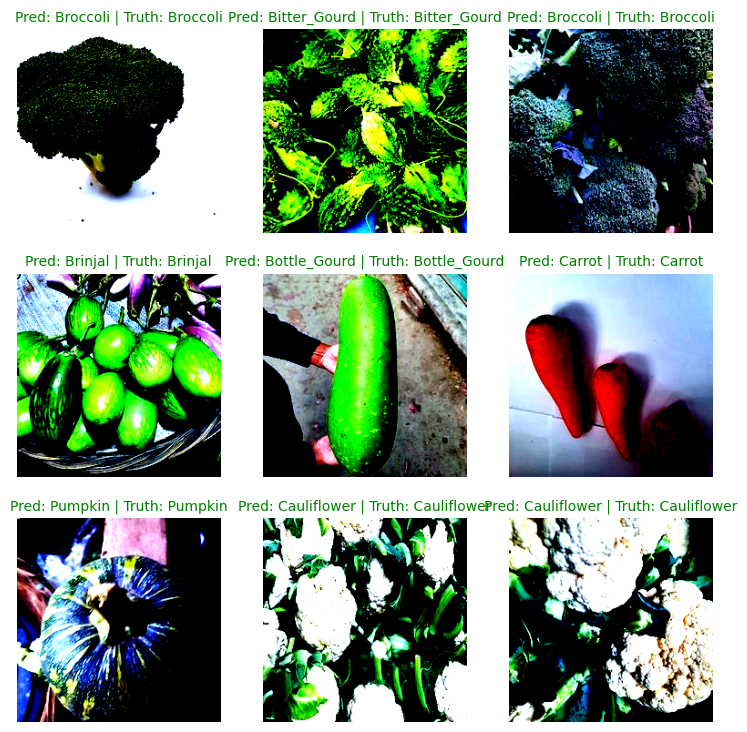

In [90]:
# Move Model to Cpu for Vizualizing
model=model.to("cpu")

fig=plt.figure(figsize=(9,9))
nrows=3
ncols=3

model.eval()

for i in range(1 , nrows * ncols + 1):
    random_indx=torch.randint(0,len(test_data),size=[1]).item()
    image,label=test_data[random_indx]

    actual_image=classes[label]
    
    model.eval()

    y_pred=model(image.unsqueeze(dim=0))

    predicted=classes[(torch.softmax(y_pred,dim=1)).argmax(dim=1).item()]

    fig.add_subplot(nrows,ncols,i)

    plt.imshow(np.asarray(image.permute(1,2,0)))

    title_text = f"Pred: {predicted} | Truth: {actual_image}"

    if predicted == actual_image:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r") 
  
    plt.axis(False)

## Classification by making Confusion Matrix on Unseen Data

In [104]:

# List of True vs Predicted Label
true_label=[]
predicted_label=[]

# Move model to GPU for Faster Computing
model=model.to(device)

# Put model in Eval mode
model.eval()

for img,label in tqdm(test_DataLoader):
    img,label=img.to(device),label.to(device)

    # Predicted Logits
    y_logits=model(img)

    # Prediction Probabilities
    y_pred=torch.softmax(y_logits,dim=1).argmax(1)


    # Xxtend to end of the list 
    true_label.extend(label)
    predicted_label.extend(y_pred)




100%|██████████| 94/94 [00:16<00:00,  5.81it/s]


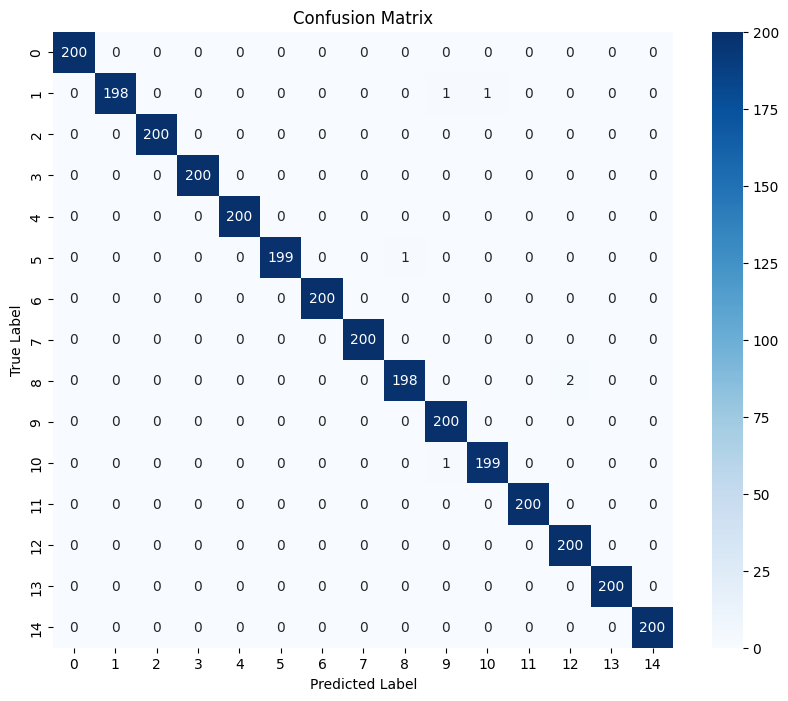

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_label_tensor = torch.tensor(true_label)
predicted_label_tensor = torch.tensor(predicted_label)

# Move tensors from GPU to CPU if they are on GPU
if true_label_tensor.is_cuda:
    true_label_tensor = true_label_tensor.cpu()
if predicted_label_tensor.is_cuda:
    predicted_label_tensor = predicted_label_tensor.cpu()

# Compute confusion matrix
cm = confusion_matrix(true_label_tensor.numpy(), predicted_label_tensor.numpy())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [110]:
def plot_loss_curves(trainLosses,trainAcc,valLosses,valAccs):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = trainLosses
  test_loss = valLosses

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = trainAcc
  test_accuracy = valAccs

  # Figure out how mnay epochs there were
  epochs = range(len(trainLosses))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend() 

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

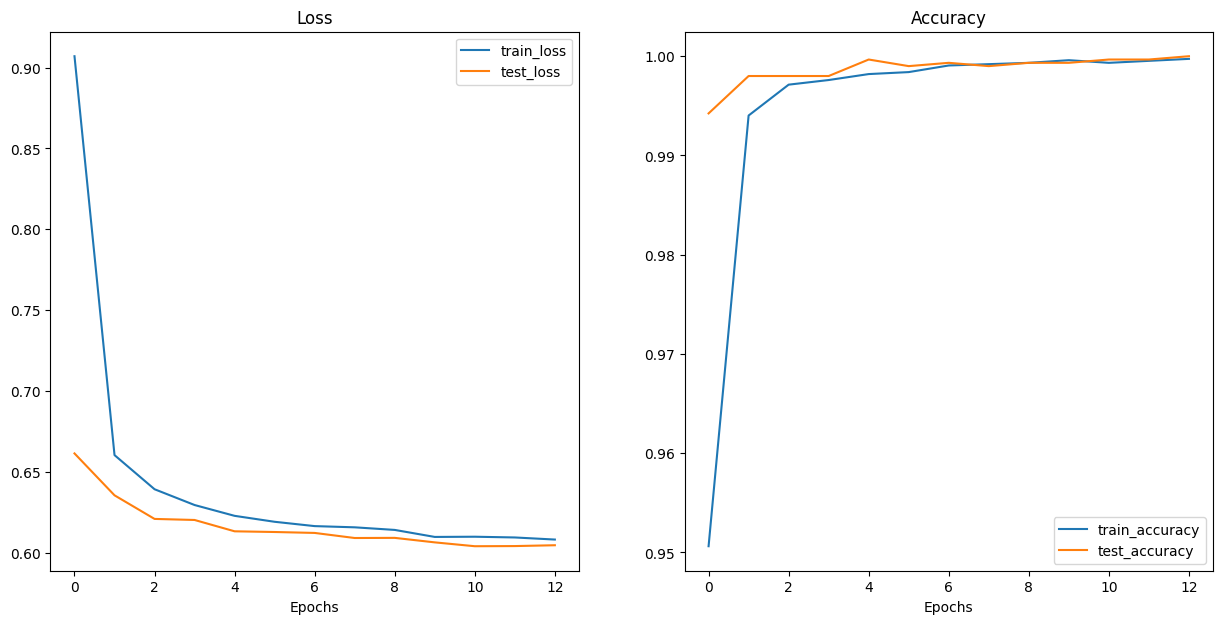

In [111]:
plot_loss_curves(trainLosses,trainAcc,valLosses,valAccs) 

# 7. Model Deployment using Gradio

In [42]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !python -m pip -q install gradio
    import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 4.24.0


In [113]:
# Put our model on the CPU
model = model.to("cpu")

# Check the device 
next(iter(model.parameters())).device

device(type='cpu')

In [44]:


def predict(img) -> Tuple[Dict, float]:
  

  # Transform the input image for use with EffNetB2
  img = Tvalransformer(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  model.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(model(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {classes[i]: float(pred_probs[0][i]) for i in range(len(classes))}

  # Return pred dict and pred time
  return pred_labels_and_probs

In [114]:
import gradio as gr

# Create title, description and article
title = "Vegetable & Recipe Recommendation System"
description = "An [ResNet50 feature extractor] computer vision model to classify images as Bean ,Bitter Gourd ,Bottle_Gourd ,Brinjal ,Cabbage ,Capsicum ,Carrot ,Cauliflour ,Cucumber ,Papaya ,Potato, Pumpkin ,Radish ,Tomato. & Provide Recipie Recomandation"
article = "Created at Gaurav Verma."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions")],
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL 

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://13091de447a7d47208.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# 8. Saving Model 

In [48]:
torch.save(best_model,"models\VegatableDetection\Best_model_state_dict_resnet50.pth")

In [49]:
torch.save(model,"models\VegatableDetection\Last_model_resnet50.pth")